# 1. Load the Karate Club network in Networkx and provide the statistics such as Degree Distribution, Centrality Measures etc. (5 marks)

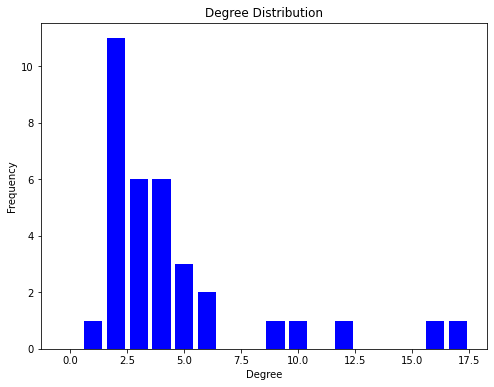

Degree Centrality: [(0, 0.48484848484848486), (1, 0.2727272727272727), (2, 0.30303030303030304), (3, 0.18181818181818182), (4, 0.09090909090909091), (5, 0.12121212121212122), (6, 0.12121212121212122), (7, 0.12121212121212122), (8, 0.15151515151515152), (9, 0.06060606060606061), (10, 0.09090909090909091), (11, 0.030303030303030304), (12, 0.06060606060606061), (13, 0.15151515151515152), (14, 0.06060606060606061), (15, 0.06060606060606061), (16, 0.06060606060606061), (17, 0.06060606060606061), (18, 0.06060606060606061), (19, 0.09090909090909091), (20, 0.06060606060606061), (21, 0.06060606060606061), (22, 0.06060606060606061), (23, 0.15151515151515152), (24, 0.09090909090909091), (25, 0.09090909090909091), (26, 0.06060606060606061), (27, 0.12121212121212122), (28, 0.09090909090909091), (29, 0.12121212121212122), (30, 0.12121212121212122), (31, 0.18181818181818182), (32, 0.36363636363636365), (33, 0.5151515151515151)]
Closeness Centrality: [(0, 0.5689655172413793), (1, 0.4852941176470588), 

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the Karate Club graph
G = nx.karate_club_graph()

# Degree distribution
degree_distribution = [degree for node, degree in G.degree()]
degree_histogram = np.bincount(degree_distribution)

# Centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Summary of the graph
# graph_info = nx.info(G)

# Plotting degree distribution
plt.figure(figsize=(8, 6))
plt.bar(range(len(degree_histogram)), degree_histogram, width=0.80, color="b")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

print("Degree Centrality:",list(degree_centrality.items())[:])
print("Closeness Centrality:",list(closeness_centrality.items())[:])
print("Betweeness Centrality:",list(betweenness_centrality.items())[:])
print("Eigenvector Centrality:",list(eigenvector_centrality.items())[:])


# 2. Convert the Karate Club Graph that you imported to a Pytorch Geometric Graph Data (5 marks)

In [31]:
import networkx as nx
from torch_geometric.utils import from_networkx

G = nx.karate_club_graph()
G_karate_pg = from_networkx(G)
print(G_karate_pg)


Data(edge_index=[2, 156], club=[34], weight=[156], name='Zachary's Karate Club', num_nodes=34)


# 3. Load the Karate Club Network in Pytorch Geometric Library (5 marks)

In [32]:
from torch_geometric.datasets import KarateClub


dataset = KarateClub()
data = dataset[0]
print(data)


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


# 4. Visualize the Karate Club graph such that nodes in the same class have the same color (5 marks)

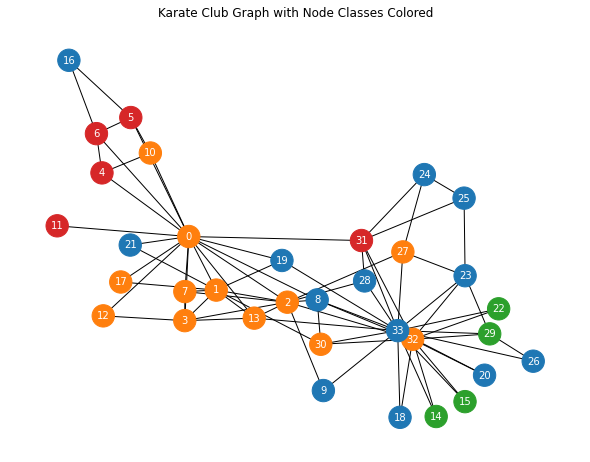

In [33]:
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.datasets import KarateClub
import networkx as nx


dataset = KarateClub()
data = dataset[0]

G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

labels = data.y.numpy()
colors = [plt.cm.tab10(label) for label in labels]

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=colors, node_size=500, font_color='white', font_size=10)
plt.title("Karate Club Graph with Node Classes Colored")
plt.show()


# 5. Implement GCN from SCRATCH (without using any pytorch geomteric functions). The implemented GCN should be a function of the following format:
```
def GCN(features, edge_list, num_layers):
  '''
  Write your code here
  '''
  return features

```



# The function should take the node features, edge_list (in the pytorch_geometric edge-list format) and return the features after 1 iteration through the graph.

# For the GCN initialize the weight vectors randomly from a gaussian distribution and for training use adam optimizer and cross entropy loss. You can use pytorch libraries for the same. (10 marks)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub

# Helper function to compute the normalized adjacency matrix
def normalize_adjacency(num_nodes, edge_list):
    # Initialize adjacency matrix
    adj = torch.zeros((num_nodes, num_nodes), device=edge_list.device)
    
    # Create the adjacency matrix
    adj[edge_list[0], edge_list[1]] = 1
    
    # Add self-loops (diagonal elements)
    adj += torch.eye(num_nodes, device=edge_list.device)

    # Compute degree matrix
    degree = adj.sum(dim=1)
    
    # Compute the normalized adjacency matrix (D^(-1/2) * A * D^(-1/2))
    degree_inv_sqrt = torch.pow(degree, -0.5)
    degree_inv_sqrt[torch.isinf(degree_inv_sqrt)] = 0  # Handle division by 0
    D_inv_sqrt = torch.diag(degree_inv_sqrt)
    adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
    
    return adj_normalized

# Define the GCN layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        # Initialize weight matrix with the correct shape
        self.weight = nn.Parameter(torch.randn(in_features, out_features))

    def forward(self, features, adj):
        # Graph convolution: A * X * W
        return adj @ features @ self.weight


# Define the complete GCN
class GCNModel(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers):
        super(GCNModel, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        # First layer
        self.layers.append(GCNLayer(in_features, hidden_features))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNLayer(hidden_features, hidden_features))
        
        # Output layer
        self.layers.append(GCNLayer(hidden_features, out_features))

    def forward(self, features, edge_list):
        num_nodes = features.size(0)
        adj = normalize_adjacency(num_nodes, edge_list)
        
        for layer in self.layers[:-1]:
            features = layer(features, adj)
            features = F.relu(features)
        
        # Output layer (no ReLU)
        features = self.layers[-1](features, adj)
        
        return features

# 6. Write a training module that does node classification using the above 'GCN' function. Use the karate_club graph from torch_geometric as a reference to test your code. (5 marks)

In [70]:
def train_gcn(features, edge_list, labels, train_mask, num_layers=2, lr=0.01, epochs=200):
    # Initialize model, optimizer, and loss function
    in_features = features.shape[1]
    hidden_features = 16  # Arbitrarily chosen hidden dimension size
    out_features = len(labels.unique())  # Number of classes (for Karate Club: 2)
    
    model = GCNModel(in_features, hidden_features, out_features, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(features, edge_list)
        
        # Compute the loss using only the nodes in the training mask
        loss = loss_fn(output[train_mask], labels[train_mask])
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model


# Prepare Karate Club data
def load_karate_club_data():
    # Load the Karate Club graph
    dataset = KarateClub()
    data = dataset[0]

    # Extract node features, edge list, labels, and train mask
    features = data.x
    edge_list = data.edge_index
    labels = data.y
    train_mask = data.train_mask

    return features, edge_list, labels, train_mask


# Load the Karate Club data
features, edge_list, labels, train_mask = load_karate_club_data()

# Train the GCN model
model = train_gcn(features, edge_list, labels, train_mask, num_layers=2, lr=0.01, epochs=200)

# Test the trained model
with torch.no_grad():
    output = model(features, edge_list)
    predicted_classes = output.argmax(dim=1)

# Compute accuracy on the full dataset
correct = (predicted_classes == labels).sum().item()
accuracy = correct / labels.size(0)

print(f'Accuracy: {accuracy:.4f}')




Epoch 0, Loss: 1.3759241104125977
Epoch 10, Loss: 1.1781995296478271
Epoch 20, Loss: 0.8921949863433838
Epoch 30, Loss: 0.5844326615333557
Epoch 40, Loss: 0.3295772969722748
Epoch 50, Loss: 0.16742590069770813
Epoch 60, Loss: 0.08665964752435684
Epoch 70, Loss: 0.05020202696323395
Epoch 80, Loss: 0.03299707919359207
Epoch 90, Loss: 0.02391928620636463
Epoch 100, Loss: 0.018553903326392174
Epoch 110, Loss: 0.015050070360302925
Epoch 120, Loss: 0.012573663145303726
Epoch 130, Loss: 0.01072450540959835
Epoch 140, Loss: 0.009290482848882675
Epoch 150, Loss: 0.008145793341100216
Epoch 160, Loss: 0.007213549222797155
Epoch 170, Loss: 0.0064411889761686325
Epoch 180, Loss: 0.005792613606899977
Epoch 190, Loss: 0.00524182477965951
Accuracy: 0.7647


# 7. Now, use the pytorch_geometric **GCNConv** function to implement the same node classification task.

# For the GCN initialize the weight vectors randomly from a gaussian distribution and for training use adam optimizer and cross entropy loss. You can use pytorch libraries for the same. (5 marks)

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub

# Define the GCN model using GCNConv
class GCNModel(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers):
        super(GCNModel, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(GCNConv(in_features, hidden_features))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_features, hidden_features))

        # Output layer
        self.layers.append(GCNConv(hidden_features, out_features))

    def forward(self, x, edge_index):
        # Loop through all the layers
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.relu(x)

        # Output layer (no activation)
        x = self.layers[-1](x, edge_index)

        return x

# Define the training function
def train_gcn(features, edge_index, labels, train_mask, num_layers=2, lr=0.01, epochs=200):
    # Initialize model, optimizer, and loss function
    in_features = features.shape[1]
    hidden_features = 16  # Hidden layer size
    out_features = len(labels.unique())  # Number of classes

    model = GCNModel(in_features, hidden_features, out_features, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        output = model(features, edge_index)

        # Compute the loss using only the nodes in the training mask
        loss = loss_fn(output[train_mask], labels[train_mask])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model

# Prepare Karate Club data
def load_karate_club_data():
    # Load the Karate Club graph
    dataset = KarateClub()
    data = dataset[0]

    # Extract node features, edge list, labels, and train mask
    features = data.x
    edge_index = data.edge_index
    labels = data.y
    train_mask = data.train_mask

    return features, edge_index, labels, train_mask


# Load the Karate Club data
features, edge_index, labels, train_mask = load_karate_club_data()

# Train the GCN model
model = train_gcn(features, edge_index, labels, train_mask, num_layers=2, lr=0.01, epochs=200)

# Test the trained model
model.eval()
with torch.no_grad():
    output = model(features, edge_index)
    predicted_classes = output.argmax(dim=1)

# Compute accuracy on the full dataset
correct = (predicted_classes == labels).sum().item()
accuracy = correct / labels.size(0)

print(f'Accuracy: {accuracy:.4f}')




Epoch 0, Loss: 1.4053505659103394
Epoch 10, Loss: 1.177832841873169
Epoch 20, Loss: 0.8986062407493591
Epoch 30, Loss: 0.6292408108711243
Epoch 40, Loss: 0.3921547830104828
Epoch 50, Loss: 0.2098972499370575
Epoch 60, Loss: 0.10625698417425156
Epoch 70, Loss: 0.056765008717775345
Epoch 80, Loss: 0.03429026901721954
Epoch 90, Loss: 0.02329757623374462
Epoch 100, Loss: 0.017279524356126785
Epoch 110, Loss: 0.013614790514111519
Epoch 120, Loss: 0.011147964745759964
Epoch 130, Loss: 0.009375601075589657
Epoch 140, Loss: 0.008035549893975258
Epoch 150, Loss: 0.006983253173530102
Epoch 160, Loss: 0.006136537529528141
Epoch 170, Loss: 0.005444096401333809
Epoch 180, Loss: 0.004867713898420334
Epoch 190, Loss: 0.004381274338811636
Accuracy: 0.8235


# 8. Increase the number of layers in the GCN module and verify how it affects the node classification result. Use the pytorch_geomteric GCNConv implementation in the previous task. Report the node classification results from **1 - 15** layers (10 marks)

Training with 1 layers...
Accuracy with 1 layers: 0.7941
Training with 2 layers...
Accuracy with 2 layers: 0.8235
Training with 3 layers...
Accuracy with 3 layers: 0.7941
Training with 4 layers...
Accuracy with 4 layers: 0.7353
Training with 5 layers...
Accuracy with 5 layers: 0.7647
Training with 6 layers...
Accuracy with 6 layers: 0.5294
Training with 7 layers...
Accuracy with 7 layers: 0.4412
Training with 8 layers...
Accuracy with 8 layers: 0.5000
Training with 9 layers...
Accuracy with 9 layers: 0.5588
Training with 10 layers...
Accuracy with 10 layers: 0.4706
Training with 11 layers...
Accuracy with 11 layers: 0.4412
Training with 12 layers...
Accuracy with 12 layers: 0.3529
Training with 13 layers...
Accuracy with 13 layers: 0.4118
Training with 14 layers...
Accuracy with 14 layers: 0.4118
Training with 15 layers...
Accuracy with 15 layers: 0.4118


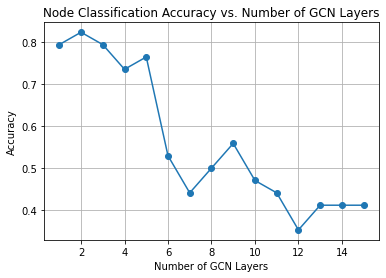

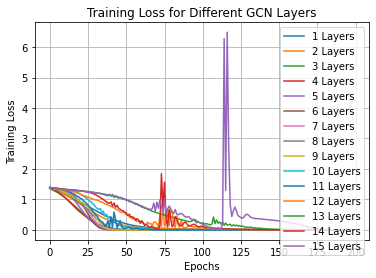

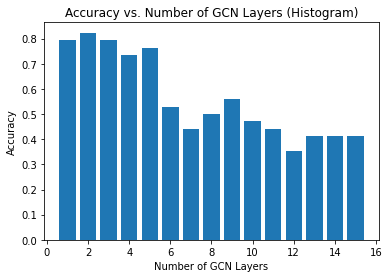

Layers: 1, Accuracy: 0.7941
Layers: 2, Accuracy: 0.8235
Layers: 3, Accuracy: 0.7941
Layers: 4, Accuracy: 0.7353
Layers: 5, Accuracy: 0.7647
Layers: 6, Accuracy: 0.5294
Layers: 7, Accuracy: 0.4412
Layers: 8, Accuracy: 0.5000
Layers: 9, Accuracy: 0.5588
Layers: 10, Accuracy: 0.4706
Layers: 11, Accuracy: 0.4412
Layers: 12, Accuracy: 0.3529
Layers: 13, Accuracy: 0.4118
Layers: 14, Accuracy: 0.4118
Layers: 15, Accuracy: 0.4118


In [57]:
# Define the training function
def train_gcn(features, edge_index, labels, train_mask, num_layers=2, lr=0.01, epochs=200):
    
    in_features = features.shape[1]
    hidden_features = 16  # Hidden layer size
    out_features = len(labels.unique())  # Number of classes

    model = GCNModel(in_features, hidden_features, out_features, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        output = model(features, edge_index)

        # Compute the loss using only the nodes in the training mask
        loss = loss_fn(output[train_mask], labels[train_mask])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return model, train_losses

# Function to test the model
def test_gcn(model, features, edge_index, labels):
    model.eval()
    with torch.no_grad():
        output = model(features, edge_index)
        predicted_classes = output.argmax(dim=1)

    # Compute accuracy
    correct = (predicted_classes == labels).sum().item()
    accuracy = correct / labels.size(0)

    return accuracy

# Prepare Karate Club data
def load_karate_club_data():
    # Load the Karate Club graph
    dataset = KarateClub()
    data = dataset[0]

    # Extract node features, edge list, labels, and train mask
    features = data.x
    edge_index = data.edge_index
    labels = data.y
    train_mask = data.train_mask

    return features, edge_index, labels, train_mask

# Main function to experiment with different GCN depths
def experiment_with_layers():
    # Load the Karate Club data
    features, edge_index, labels, train_mask = load_karate_club_data()

    # Range of layers to test (from 1 to 15)
    num_layers_list = list(range(1, 16))
    accuracies = []
    all_train_losses = []
    epochs = 200  # Fixed number of epochs

    for num_layers in num_layers_list:
        print(f"Training with {num_layers} layers...")
        # Train the GCN model and get training loss
        model, train_losses = train_gcn(features, edge_index, labels, train_mask, num_layers=num_layers, lr=0.01, epochs=epochs)

        # Test the trained model
        accuracy = test_gcn(model, features, edge_index, labels)
        accuracies.append(accuracy)
        all_train_losses.append(train_losses)

        print(f"Accuracy with {num_layers} layers: {accuracy:.4f}")
    
    # Plot the accuracies for different numbers of layers
    plt.plot(num_layers_list, accuracies, marker='o')
    plt.xlabel('Number of GCN Layers')
    plt.ylabel('Accuracy')
    plt.title('Node Classification Accuracy vs. Number of GCN Layers')
    plt.grid(True)
    plt.show()

    # Plot training loss for each layer count
    for num_layers, train_losses in zip(num_layers_list, all_train_losses):
        plt.plot(range(epochs), train_losses, label=f'{num_layers} Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss for Different GCN Layers')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Make histogram of accuracies
    plt.bar(num_layers_list, accuracies)
    plt.xlabel('Number of GCN Layers')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of GCN Layers (Histogram)')
    plt.show()

    # Print final results
    for num_layers, accuracy in zip(num_layers_list, accuracies):
        print(f"Layers: {num_layers}, Accuracy: {accuracy:.4f}")

experiment_with_layers()


# 9. Save the neighbors of each node in the Karate Club Network in a dictionary with node number as the key and list of neighbors as the value. (5 marks)

{0: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31], 1: [0, 2, 3, 7, 13, 17, 19, 21, 30], 2: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32], 3: [0, 1, 2, 7, 12, 13], 4: [0, 6, 10], 5: [0, 6, 10, 16], 6: [0, 4, 5, 16], 7: [0, 1, 2, 3], 8: [0, 2, 30, 32, 33], 9: [2, 33], 10: [0, 4, 5], 11: [0], 12: [0, 3], 13: [0, 1, 2, 3, 33], 14: [32, 33], 15: [32, 33], 16: [5, 6], 17: [0, 1], 18: [32, 33], 19: [0, 1, 33], 20: [32, 33], 21: [0, 1], 22: [32, 33], 23: [25, 27, 29, 32, 33], 24: [25, 27, 31], 25: [23, 24, 31], 26: [29, 33], 27: [2, 23, 24, 33], 28: [2, 31, 33], 29: [23, 26, 32, 33], 30: [1, 8, 32, 33], 31: [0, 24, 25, 28, 32, 33], 32: [2, 8, 14, 15, 18, 20, 22, 23, 29, 30, 31, 33], 33: [8, 9, 13, 14, 15, 18, 19, 20, 23, 26, 27, 28, 29, 30, 31, 32, 22]}


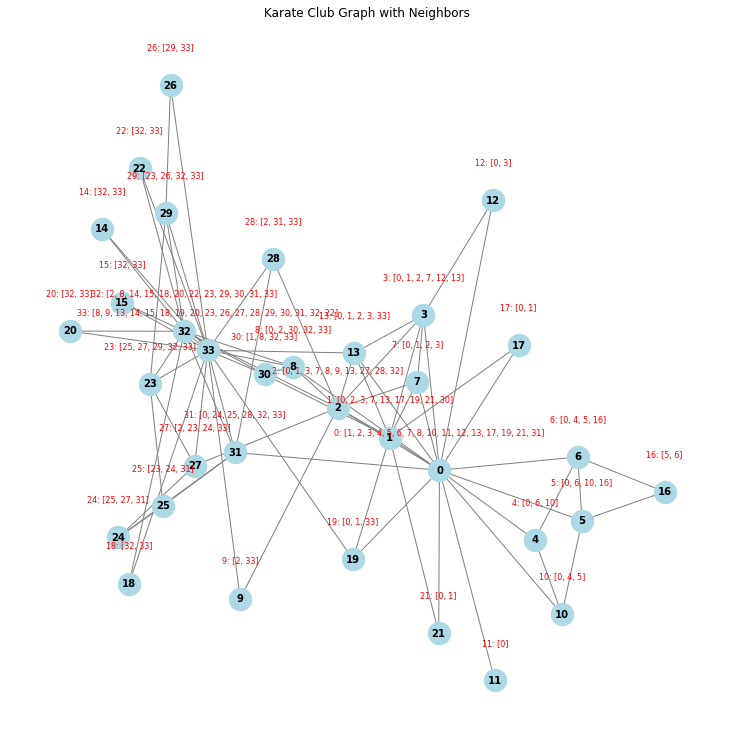

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the Karate Club Network
G = nx.karate_club_graph()

# Create a dictionary to store neighbors
neighbors_dict = {}

# Iterate over each node and its neighbors
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    neighbors_dict[node] = neighbors

print(neighbors_dict)

# Visualize the graph
plt.figure(figsize=(10, 10))


pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_color='black', font_weight='bold', edge_color='gray')

for node, neighbors in neighbors_dict.items():
    label = f"{node}: {neighbors}"
    plt.text(pos[node][0], pos[node][1] + 0.05, label, horizontalalignment='center', fontsize=8, color='red')

plt.title("Karate Club Graph with Neighbors")
plt.show()


# 10. Now extract the features of every node (using the GCN model from torch_geometric that you trained for Karate Club in the previous step) and save them in a variable (5 marks)

In [47]:
# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]  # Single graph in dataset

# Create the GCN model
in_features = dataset.num_node_features  # Number of input features
hidden_features = 16  # Number of hidden features
out_features = dataset.num_classes  # Number of output features
num_layers = 3  # Number of layers
model = GCNModel(in_features, hidden_features, out_features, num_layers)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Set the model to evaluation mode
model.eval()

# Extract features for each node
with torch.no_grad():
    node_features = model(data.x, data.edge_index)

# Convert to numpy if needed
node_features_np = node_features.numpy()


print(node_features_np)


[[  1.1987276    9.268209   -26.913864     0.5911037 ]
 [  2.765084     6.91519    -15.19353     -6.998991  ]
 [  3.4313402   -0.99913394  -7.5272446   -8.275808  ]
 [  2.2253523    6.5200834  -13.947346    -5.5561657 ]
 [ -1.228518     4.4505577  -22.098589    12.603968  ]
 [ -1.8863695    4.978425   -26.729067    16.798805  ]
 [ -1.8907032    4.96163    -26.751564    16.855099  ]
 [  2.0733814    4.7104053  -11.550275    -4.283924  ]
 [  3.5471046   -3.8029938   -4.4065795   -4.8693414 ]
 [  2.947925    -3.943686    -1.231992    -5.0924635 ]
 [ -1.2290711    4.4718156  -22.087774    12.569468  ]
 [  1.106082     5.2835474  -11.389328    -1.9683033 ]
 [  1.2750742    5.6068926  -11.6780205   -2.6662421 ]
 [  2.7160604    2.2040615   -9.883414    -4.910135  ]
 [  3.497742    -7.062805     0.8729443   -4.4714317 ]
 [  3.470143    -7.0694017    0.9044532   -4.439981  ]
 [ -2.0070546    3.69343    -23.340761    16.647896  ]
 [  1.4385234    4.9805355  -11.230936    -2.43055   ]
 [  3.5020

# 11. Now for every node calculate the cosine similarity of its features with the features of every other node and save it in a ordered list (ordered by descending order of cosine similarity). (5 marks)

For example if the ordered list for node 0 has [0, 1, 6, 2, 8, .., 34] then it means node features of node 0 has the most similarity with features of node 0, then node 1, node 6 and so on.

Do this for all the nodes

In [40]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarities and sort them
def compute_cosine_similarities(node_features):
    num_nodes = node_features.shape[0]
    cosine_similarities = []

    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(node_features)
    
    for i in range(num_nodes):
        
        similarities = sim_matrix[i]
        
        # Create a list of (node_index, similarity) and sort it
        similarity_list = [(index, similarity) for index, similarity in enumerate(similarities)]
        similarity_list.sort(key=lambda x: x[1], reverse=True)
        
        # Extract the ordered list of node indices based on similarity
        ordered_node_indices = [index for index, _ in similarity_list]
        cosine_similarities.append(ordered_node_indices)
    
    return cosine_similarities

node_features_np = node_features.numpy()


ordered_similarities = compute_cosine_similarities(node_features_np)


for node_index, ordered_list in enumerate(ordered_similarities):
    print(f"Node {node_index}: {ordered_list}")


Node 0: [0, 12, 11, 21, 17, 3, 7, 1, 13, 19, 4, 10, 6, 5, 2, 16, 8, 30, 9, 33, 32, 18, 15, 22, 14, 20, 26, 29, 28, 23, 27, 31, 25, 24]
Node 1: [1, 7, 3, 13, 19, 17, 2, 21, 8, 30, 9, 33, 32, 15, 18, 22, 14, 20, 26, 12, 29, 28, 23, 27, 31, 0, 25, 24, 11, 4, 10, 6, 5, 16]
Node 2: [2, 8, 30, 9, 19, 33, 13, 32, 18, 15, 20, 22, 14, 26, 29, 28, 1, 7, 23, 3, 27, 31, 17, 21, 12, 25, 24, 0, 11, 4, 10, 6, 5, 16]
Node 3: [3, 7, 1, 17, 13, 19, 21, 2, 12, 8, 30, 9, 33, 32, 15, 18, 22, 14, 20, 26, 29, 28, 0, 23, 27, 31, 11, 25, 24, 4, 10, 6, 5, 16]
Node 4: [4, 10, 6, 5, 16, 11, 0, 12, 21, 17, 3, 7, 24, 1, 25, 13, 19, 2, 8, 31, 30, 27, 9, 33, 32, 15, 22, 18, 14, 20, 28, 23, 26, 29]
Node 5: [5, 6, 10, 4, 16, 11, 0, 12, 21, 17, 3, 24, 7, 1, 25, 13, 19, 2, 31, 8, 30, 27, 9, 33, 32, 15, 22, 18, 14, 23, 20, 28, 26, 29]
Node 6: [6, 5, 10, 4, 16, 11, 0, 12, 21, 17, 3, 24, 7, 1, 25, 13, 19, 2, 31, 8, 30, 27, 9, 33, 32, 15, 22, 18, 14, 23, 20, 28, 26, 29]
Node 7: [7, 1, 3, 13, 19, 17, 21, 2, 8, 30, 9, 33, 32, 

# 12. Now select the top-k nodes from the above ordered list. The value of k for each node will be equal to its number of neighbors in the actual karate club graph. Save these top k neighbors of every node in a list of lists. (5 marks)

In [49]:
# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

# node_features_np should be of shape [num_nodes, num_features]
node_features_np = node_features.numpy()

# Compute cosine similarities and get ordered lists
ordered_similarities = compute_cosine_similarities(node_features_np)

# Create a graph to get the number of neighbors
G = nx.karate_club_graph()

# Create a list of lists to store the top-k neighbors for each node
top_k_neighbors = []

# Iterate through each node
for node in G.nodes():
    # Get the number of neighbors
    num_neighbors = len(list(G.neighbors(node)))
    
    # Get the top-k nodes based on cosine similarity
    top_k = ordered_similarities[node][:num_neighbors]
    
    # Append the top-k neighbors to the list
    top_k_neighbors.append(top_k)

# Print or save the results
for node_index, neighbors in enumerate(top_k_neighbors):
    print(f"Node {node_index}: {neighbors}")


Node 0: [0, 11, 17, 21, 12, 7, 3, 1, 19, 10, 4, 13, 5, 6, 16, 2]
Node 1: [1, 3, 7, 21, 12, 17, 13, 11, 19]
Node 2: [2, 8, 13, 19, 30, 1, 7, 3, 9, 21]
Node 3: [3, 7, 1, 21, 12, 17]
Node 4: [4, 10, 5]
Node 5: [5, 6, 4, 10]
Node 6: [6, 5, 4, 10]
Node 7: [7, 3, 1, 21]
Node 8: [8, 30, 9, 2, 33]
Node 9: [9, 30]
Node 10: [10, 4, 5]
Node 11: [11]
Node 12: [12, 21]
Node 13: [13, 19, 7, 1, 3]
Node 14: [14, 15]
Node 15: [15, 22]
Node 16: [16, 6]
Node 17: [17, 21]
Node 18: [18, 15]
Node 19: [19, 13, 7]
Node 20: [20, 15]
Node 21: [21, 17]
Node 22: [22, 15]
Node 23: [23, 27, 31, 25, 29]
Node 24: [24, 25, 23]
Node 25: [25, 24, 23]
Node 26: [26, 29]
Node 27: [27, 31, 23, 25]
Node 28: [28, 33, 32]
Node 29: [29, 26, 32, 31]
Node 30: [30, 8, 9, 2]
Node 31: [31, 27, 23, 29, 28, 32]
Node 32: [32, 33, 26, 22, 14, 15, 18, 20, 28, 29, 31, 27]
Node 33: [33, 32, 28, 26, 22, 14, 15, 18, 20, 31, 29, 27, 23, 9, 25, 24, 30]


# 13. Now consider the list created in the previous step as an adjacency list and plot the new graph (5 marks)

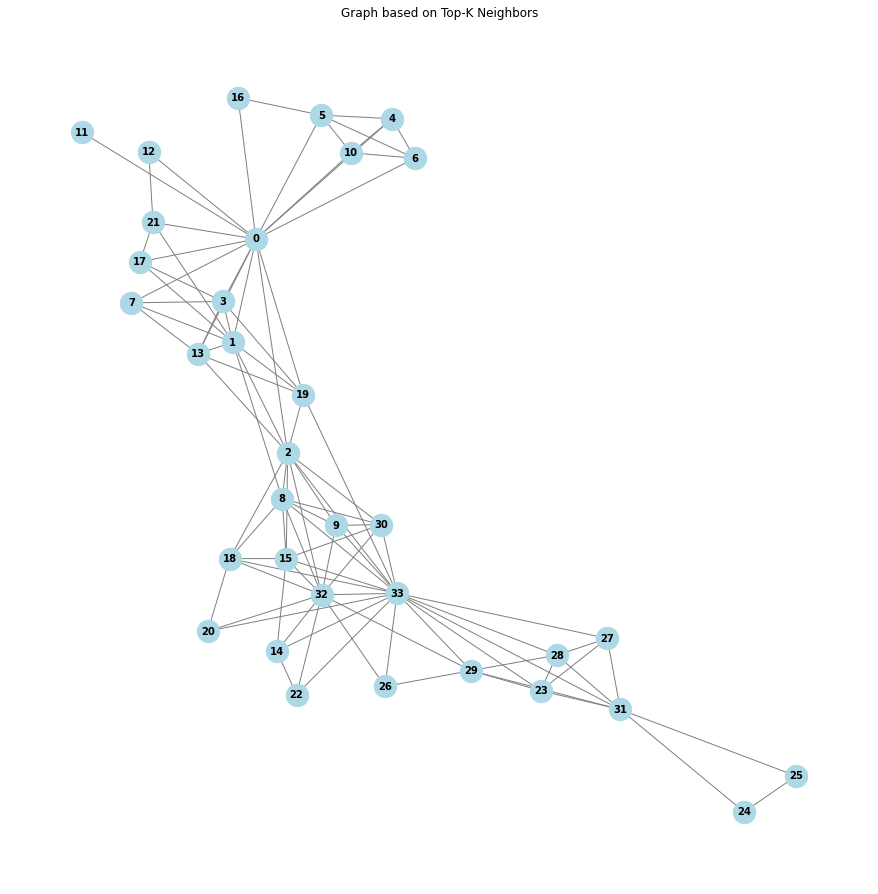

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Assume top_k_neighbors is the list of lists obtained from the previous step
# top_k_neighbors[node] contains the top-k neighbors for 'node'

# Create a new graph
new_graph = nx.Graph()

# Add nodes
num_nodes = len(top_k_neighbors)
new_graph.add_nodes_from(range(num_nodes))

# Add edges based on the top-k neighbors
for node, neighbors in enumerate(top_k_neighbors):
    for neighbor in neighbors:
        # Add an edge between node and each of its top-k neighbors
        if node != neighbor:  # Avoid self-loops
            new_graph.add_edge(node, neighbor)

# Plot the new graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(new_graph, seed=42)  # Positions for all nodes
nx.draw(new_graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Graph based on Top-K Neighbors')
plt.show()


# 14.1 Repeat the above steps from 10 to 13 by increasing the number of layers in the GCN and see how the new graph changes. Draw the graphs. (5 marks)

Training GCN with 3 layers...


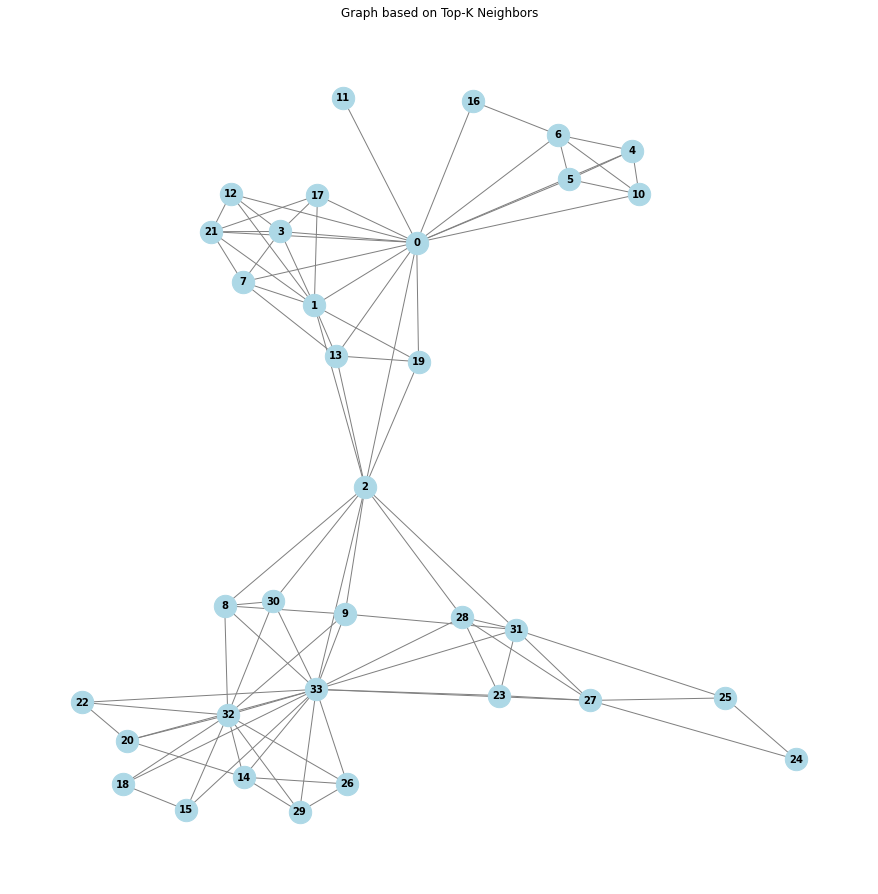

Training GCN with 6 layers...


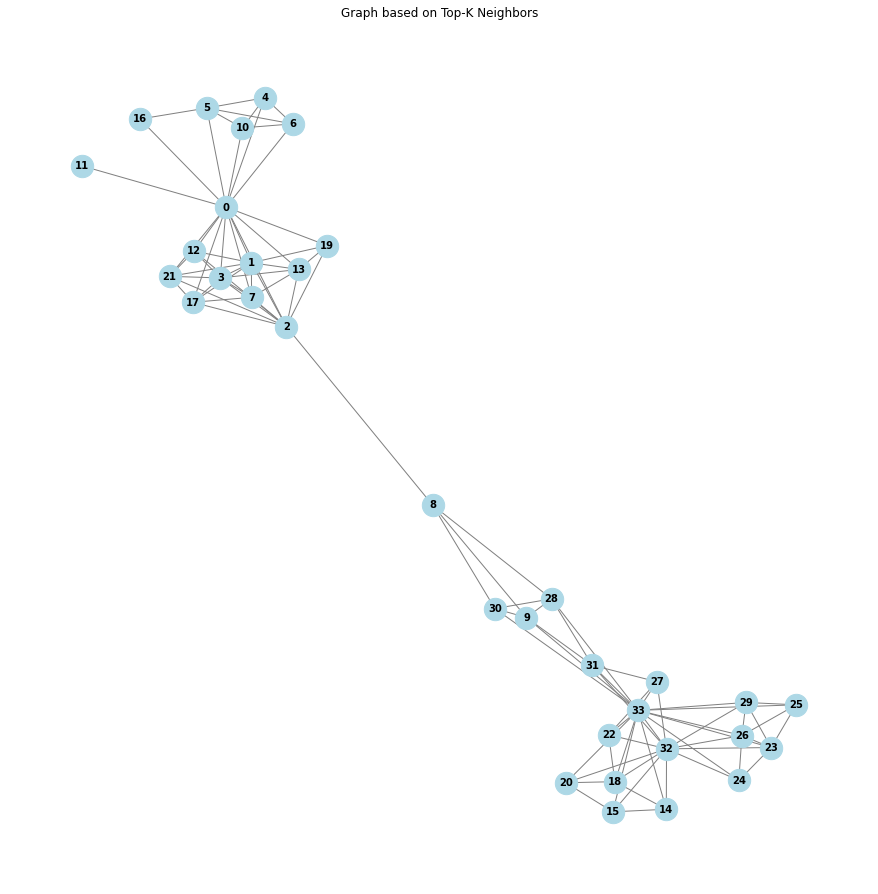

Training GCN with 9 layers...


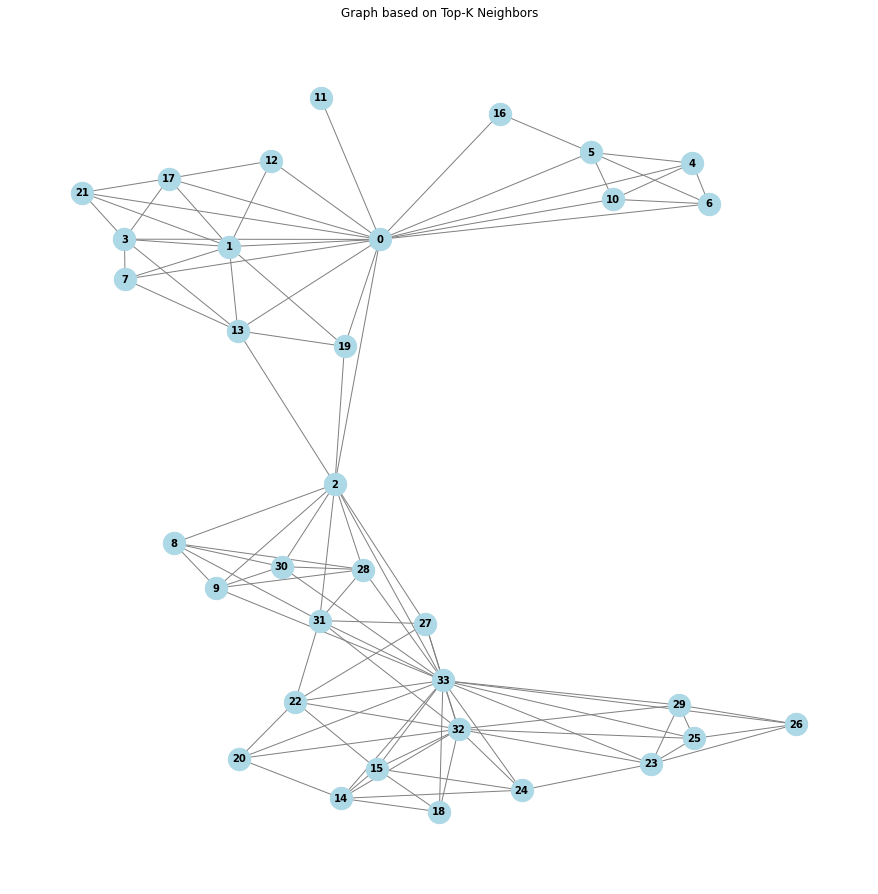

In [71]:
# Loop through different configurations of layers
layer_configs = [3,6,9]  # Original, 3x, and 3x again
for num_layers in layer_configs:
    print(f"Training GCN with {num_layers} layers...")
    
    # Create the GCN model
    model = GCNModel(in_features, hidden_features, out_features, num_layers)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    
    # Set the model to evaluation mode
    model.eval()

    # Extract features for each node
    with torch.no_grad():
        node_features = model(data.x, data.edge_index)

    # Compute cosine similarities and get ordered lists
    ordered_similarities = compute_cosine_similarities(node_features.numpy())

    # Create a graph to get the number of neighbors
    G = nx.karate_club_graph()

    # Create a list of lists to store the top-k neighbors for each node
    top_k_neighbors = []
    for node in G.nodes():
        num_neighbors = len(list(G.neighbors(node)))
        top_k = ordered_similarities[node][:num_neighbors]
        top_k_neighbors.append(top_k)

    # Plot the new graph based on top-k neighbors
    plot_graph(top_k_neighbors)


## 14.2 Write a detailed analysis. Analysis (10 marks)

1. The Karate Club network's centrality metrics show distinct node importance based on Degree, Closeness, Betweenness, and Eigenvector Centrality:

- Degree Centrality highlights node 33 (0.515) as the most connected, followed by node 0 (0.485) and node 32 (0.364). Nodes 11, 14, and 16 are the least connected (0.030).

This metric indicates node 0, node 32 node 33 play critical roles in network structure and connectivity.


2. The Karate Club network was processed using PyTorch Geometric to represent it as a graph data structure. The graph consists of 34 nodes and 156 edges.
Edge Index: Represents the connections between nodes. There are 156 edges, encoded in a 2D tensor.
Club: The graph contains 34 nodes, each representing a member of Karate Club.

5,6. 
Model Architecture:
    GCN Layers: Consists of multiple GCNLayer instances with ReLU activation applied between hidden layers. The final layer outputs the class predictions without activation.
    Normalization: The adjacency matrix is normalized using the formula D^−1/2*A*D^−1/2​.

Training Details:
    Epochs: The model was trained for 200 epochs.
    Learning Rate: Set to 0.01.
    Loss Function: CrossEntropyLoss was used to measure the prediction error.
    Optimizer: Adam optimizer.

Training Progress:
    Initial Loss: 1.4079
    Loss at Epoch 200: 0.0055
    Loss Decrease: Significant decrease in loss indicates effective learning.

Model Performance:
    Accuracy: 76.47% on the entire dataset.

7. The accuracy comes out to be 82.35%

8. As we increase the layers the node classification accuracy decreases not linearly but a trend can be seen.

11. The cosine similarity analysis reveals the ranking of nodes based on their feature similarity. Each node's most similar nodes are listed in descending order of similarity. This ranking helps identify closely related nodes within the Karate Club dataset, which can be useful for understanding node relationships and clustering in the graph.

12. Node 0 has a diverse set of top neighbors including nodes with varying levels of similarity, such as nodes 11, 17, and 21. This reflects its broad connectivity within the graph.
Node 1 shows high similarity with nodes 3, 7, and 21, aligning with its role in the graph structure.
Nodes with few neighbors like 4, 5, and 6 have limited top-k neighbors, suggesting less connectivity and possibly more isolated positions in the graph.
Nodes with complex connectivity such as 30, 31, 32, and 33 exhibit a wider range of top-k neighbors, indicating more complex relationships and interactions within the network.

14.1 If the number of layers is k then each node aggregates the information from all neighbourss upto k distance from it. So if the number of layers increases or tends to approach the diameter of graph then each node starts to accumulate the information of all other nodes of graph. Hence there is no difference in different node embeddings i.e. they are smoothed and lack expresiveness.

**10 marks kept for exceptional work**